In [1]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels_ = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels_, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


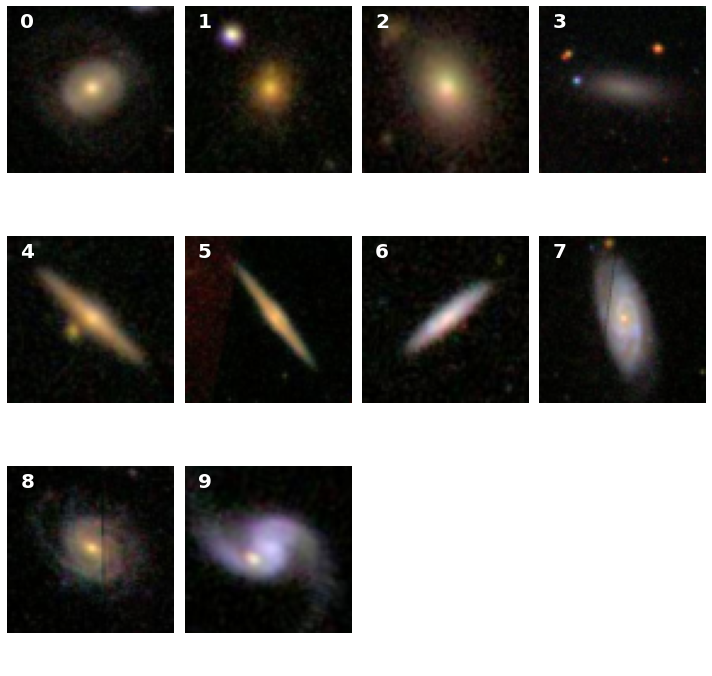

In [2]:
import matplotlib.pyplot as plt
np.random.seed(0)

fig, axs = plt.subplots(3, 4,figsize=(10,10))
axs = axs.ravel()

[ax.set_axis_off() for ax in axs]

for i,x in enumerate(np.random.rand(10)):
    ims_i = images[labels[:,i]==1] # select images of given label
    arg = int(x*len(ims_i)) #take random index
    axs[i].imshow(ims_i[arg,:,:,:]/np.max(ims_i[arg,:,:,:]),origin='lower')
    
    axs[i].text(5,60,i,c='white',weight='bold',fontsize=20)
    axs[i].axis('off')
    
plt.tight_layout()

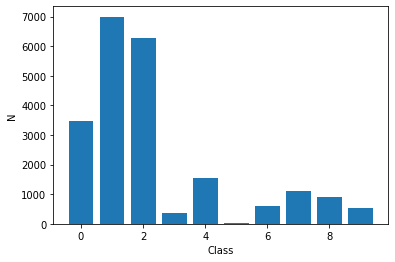

In [3]:
plt.bar(np.arange(10), np.sum(labels,axis=0))
plt.xlabel('Class')
plt.ylabel('N')
plt.show()

In [4]:
import datetime, os
import numpy as np
import warnings

# from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Activation, BatchNormalization
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


In [5]:
from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(41)

# make an array with the indices of all the rows in the dataset
ind_arr = np.arange(images.shape[0])
rnd.shuffle(ind_arr)


train_percentage, valid_percentage, test_percentage = (0.90, 0.05, 0.05)
train_ind, tmp = train_test_split(ind_arr, train_size=train_percentage, random_state=rnd)
valid_ind, test_ind = \
      train_test_split(tmp, train_size=valid_percentage/(valid_percentage + test_percentage), 
                               random_state=rnd)

In [6]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

# Don't cheat - fit only on training data
train_X = images[train_ind]
train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)

# apply same transformation to test, validation data
test_X = images[test_ind]
test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
valid_X = images[valid_ind]
valid_X = scaler.transform(valid_X.reshape(-1, valid_X.shape[-1])).reshape(valid_X.shape)

train_y = labels[train_ind] ; test_y = labels[test_ind] ; valid_y = labels[valid_ind]

assert train_y.shape[0] == train_X.shape[0]
assert test_y.shape[0] == test_X.shape[0]
assert valid_y.shape[0] == valid_X.shape[0]

In [7]:
# add with tf.device('/gpu:0'): if on GPU

input_shape = train_X[0].shape + (1,)
with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv3D(32, (3, 3, 1), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))

    model.add(Conv3D(64, (3, 3, 1), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))

    model.add(Conv3D(128, (3, 3, 1), input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dense(32, activation='relu'))


    model.add(Dense(10))
    model.add(Activation('softmax'))

In [8]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [9]:
seed = 42
batch_size = 256

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=train_X, 
          y=train_y, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(test_X, test_y), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-04-04T22:48.h5
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-9-977e2fedecb8>", line 27, in <cell line: 27>
      model.fit(x=train_X,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 767, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 623, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 589, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization/FusedBatchNormV3'
Detected at node 'sequential/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-9-977e2fedecb8>", line 27, in <cell line: 27>
      model.fit(x=train_X,
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 767, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 623, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/alizabeverage/opt/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 589, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization/FusedBatchNormV3'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  input must be 4-dimensional[256,67,67,3,32]
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]]
	 [[gradient_tape/sequential/activation_2/ReluGrad/_42]]
  (1) INVALID_ARGUMENT:  input must be 4-dimensional[256,67,67,3,32]
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1164]